# Regularización en redes neuronales

### Procesamiento de Lenguaje Natural

**Pablo Martínez Olmos, Vanessa Gómez Verdejo, Emilio Parrado Hernández**

Departamento de Teoría de la Señal y Comunicaciones

**Universidad Carlos III de Madrid**

<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />


## 1. Clasificación de imágenes. Fashion-MNIST

En este segundo notebook, utilizaremos la base de datos de imágenes [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Fashion-MNIST es un conjunto de imágenes de ropa en escala de grises de 28x28 clasificadas en 10 categorías. La base de datos es suficientemente compleja como para que una MLP no encuentra una buena solución en términos de generalización en datos de test y acabe sobreajustando. En este notebook mostraremos cómo controlar el sobreajuste con *early stopping* y *dropout*.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

### 1.2 Descarga de FMNIST con `torchvision`

La base de datos puedes descargarse de forma sencilla a través del paquete `torchvision`. El [torchvision] (https://pytorch.org/docs/stable/torchvision/index.html) proporciona datasets de uso común, arquitecturas de modelos y transformaciones de imágenes comunes para aplicaciones de visión por ordenador.

El siguiente código descargará el conjunto de datos FMNIST y luego creará conjuntos de datos de entrenamiento y test. 

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Hemos cargado nuestros datos en una clase de tipo [`DataLoader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) llamada `trainloader` y que convertimos en un iterador con` iter(trainloader) `. 

Vamos a echar un vistazo a un mini-batch de datos y representar una muestra.


In [4]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Podemos ver cómo hay 10 categorías distintas

In [5]:
print(labels)

tensor([1, 8, 4, 8, 7, 4, 9, 0, 6, 5, 3, 3, 7, 0, 1, 1, 0, 7, 9, 0, 0, 8, 4, 4,
        4, 9, 2, 1, 3, 9, 7, 1, 4, 8, 4, 2, 9, 6, 2, 7, 8, 4, 8, 0, 0, 5, 4, 5,
        8, 7, 6, 0, 0, 1, 0, 1, 5, 2, 5, 3, 9, 0, 1, 7])


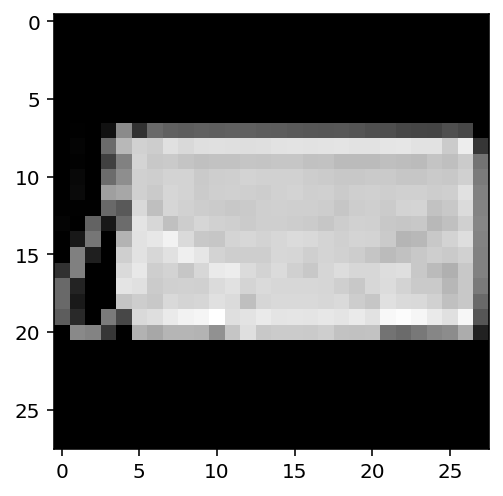

In [6]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## 2. Visualizando el sobreajuste. Early stopping

En el siguiente código definimos una red MLP con cuatro capas, dimensiones ocultas 256, 128 y 64 neuronas, y activaciones en las capas intermedias de tipo ReLU. Como ahora tenemos un clasificador multi-clase
utilizaremos una *softmax* para calcular las probabilidades de clase. En el código que se proporciona, se usa `nn.LogSoftmax` en lugar de `nn.Softmax ()`, que devuelve el **logaritmo** de la probabilidad de clase. 
La función de coste de la entropía cruzada se obtiene combinando `nn.LogSoftmax` con la función de coste *negative log-likelihood* ` nn.NLLLoss () `.


In [7]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels=10): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) #Con dim=1 indicamos que cada fila a la salida de la función de activación suma 1                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x) 
        return x

Extendemos la clase añadiendo método de entrenamiento. Esta clase es muy parecida a la del notebook anterior, con dos pequeñas diferencias:
* Reemplazamos la función de coste, ahora usamos `nn.NLLLoss()`
* Ahora usamos [Adam](https://ruder.io/optimizing-gradient-descent/) como optimizador
* Iteramos sobre trainloader

In [21]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #Reiniciamos gradientes
            
                out = self.forward(images.view(images.shape[0], -1))

                #Función de coste en el batch
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Calculamos gradientes
                loss.backward()
                
                #Una iteración de descenso por gradiente
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))


Entrenemos la red ...

In [36]:
my_MLP = MLP_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader)

Training loss after 0 epochs: 0.519741
Training loss after 1 epochs: 0.373290
Training loss after 2 epochs: 0.337518
Training loss after 3 epochs: 0.312266
Training loss after 4 epochs: 0.292555
Training loss after 5 epochs: 0.278370
Training loss after 6 epochs: 0.259839
Training loss after 7 epochs: 0.249522
Training loss after 8 epochs: 0.240139
Training loss after 9 epochs: 0.229212
Training loss after 10 epochs: 0.219451
Training loss after 11 epochs: 0.209453
Training loss after 12 epochs: 0.201269
Training loss after 13 epochs: 0.192240
Training loss after 14 epochs: 0.186281
Training loss after 15 epochs: 0.178101
Training loss after 16 epochs: 0.172190
Training loss after 17 epochs: 0.162804
Training loss after 18 epochs: 0.155934
Training loss after 19 epochs: 0.151308
Training loss after 20 epochs: 0.147866
Training loss after 21 epochs: 0.138869
Training loss after 22 epochs: 0.138078
Training loss after 23 epochs: 0.130848
Training loss after 24 epochs: 0.126301
Training l

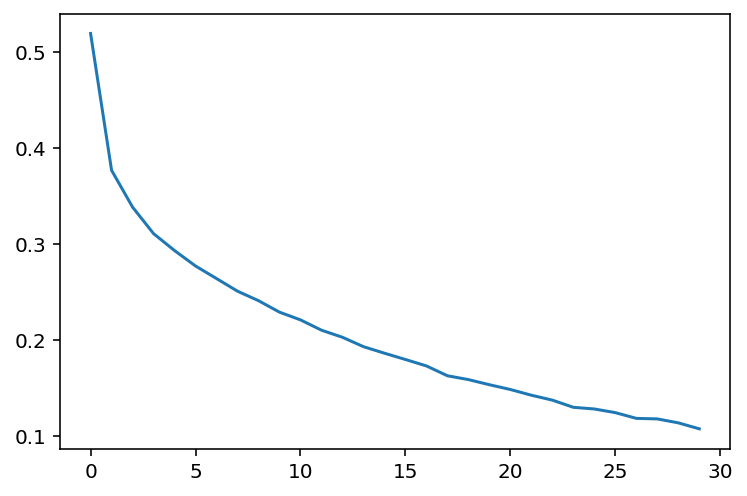

In [22]:
plt.plot(my_MLP.loss_during_training)

Usamos la siguiente función para calcular el porcentaje de etiquetas correctas en train/test. Observad que hacemos el cálculo por mini-batches ...

In [34]:
from sklearn.metrics import accuracy_score

def accuracy(dataloader,model):

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        
        accuracy = 0.
            
        for images,labels in dataloader:
            
            logprobs = model.forward(images.view(images.shape[0], -1)).detach().numpy()
            
            prediction = np.argmax(logprobs,1)
            
            accuracy += accuracy_score(labels.numpy(),prediction,normalize=True)
        
        return accuracy/len(dataloader)

In [35]:
print(f"Train accuracy {accuracy(trainloader,my_MLP)}")
print(f"Test accuracy {accuracy(testloader,my_MLP)}")

Train accuracy 0.9544243070362474
Test accuracy 0.8816679936305732


A la luz de los resultados anteriores, ciertamente el modelo se está desempeñando significativamente mejor en el conjunto de entrenamiento que en el conjunto de test. Este es un signo de sobreajuste. Para una detección temprana del sobreajuste, haremos uso de un **conjunto de validación** que usaremos para visualizar la evolución de la función de pérdida durante el entrenamiento y así implementar early stopping.

Con el siguiente código, dividimos el conjunto de trenes en un conjunto de entrenamiento (de 45k imágenes) y un conjunto de validación (de 15k imágenes)


In [48]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]


> **Ejercicio**: Complete el código de la siguiente  clase, en la que modificamos la clase `MLP_extended` anterior para que, durante el entrenamiento, cada vez que termine una época, calcule la función de pérdida sobre el conjunto de validación. Debe almacenar estos valores en un nombre de lista como `valid_loss_during_training`. Al realizar este paso, no olvide apagar los gradientes usando `with torch.no_grad()`.
>
> Luego, repita el entrenamiento (30 épocas) y dibuje la evolución de la función de coste en entrenamiento y validación.

In [49]:
class MLP_extended2(MLP):
    
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()             
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
    
    
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            running_loss = 0.
            
            for images, labels in trainloader:              
        
                self.optim.zero_grad()  #Reiniciamos gradientes
            
                out = self.forward(images.view(images.shape[0], -1))

                #Función de coste en el batch
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Calculamos gradientes
                loss.backward()
                
                #Una iteración de descenso por gradiente
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # Validation Loss
            
            # Desabilitamos gradientes para validación
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    out = #####YOUR CODE HERE

                    loss = #####YOUR CODE HERE

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(#####YOUR CODE HERE)    
                    

            if(e % 1 == 0): # Every 1 epoch(s)

                print("Epoch %d. Training loss: %f, Validation loss: %f" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1]))
                

In [51]:
my_MLP = MLP_extended2(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.549259, Validation loss: 0.419221
Epoch 1. Training loss: 0.390165, Validation loss: 0.382895
Epoch 2. Training loss: 0.352746, Validation loss: 0.350751
Epoch 3. Training loss: 0.323436, Validation loss: 0.348483
Epoch 4. Training loss: 0.301670, Validation loss: 0.389026
Epoch 5. Training loss: 0.288789, Validation loss: 0.348292
Epoch 6. Training loss: 0.273140, Validation loss: 0.337705
Epoch 7. Training loss: 0.258058, Validation loss: 0.345703
Epoch 8. Training loss: 0.245573, Validation loss: 0.343057
Epoch 9. Training loss: 0.233944, Validation loss: 0.364486
Epoch 10. Training loss: 0.224563, Validation loss: 0.315759
Epoch 11. Training loss: 0.212907, Validation loss: 0.350412
Epoch 12. Training loss: 0.205186, Validation loss: 0.336984
Epoch 13. Training loss: 0.192763, Validation loss: 0.345616
Epoch 14. Training loss: 0.186314, Validation loss: 0.331608
Epoch 15. Training loss: 0.176020, Validation loss: 0.358214
Epoch 16. Training loss: 0.169480,

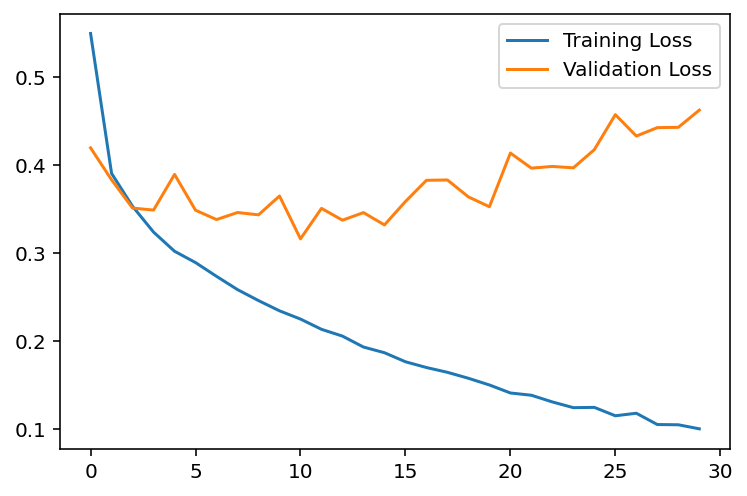

In [52]:
#Dibujemos la función de perdidas en train/validacion

### YOUR CODE HERE

> **Ejercicio**: Calcule el porcentaje de aciertos en el conjunto de entrenamiento, validación y de test

In [55]:
### YOUR CODE HERE

Train accuracy 0.9710804332386364
Validation accuracy 0.8912012411347517
Test accuracy 0.8878383757961783


A la vista de los resultados, el sobreajuste es evidente y comienza a ocurrir en torno a la época 5-10. Este es el punto de parada del entrenamiento para asegurar una mejor generalización del modelo. Esta técnica se conoce como *early stopping*. En modelos muy profundos, en los que el coste de re-entrenamiento es alto, se recomienda guardar los parámetros del modelo cada ciertas épocas y recuperar estos valores para el punto de early stopping adecuado.

> **Ejercicio:** De acuerdo con sus resultados, vuelva a entrenar el modelo para el número correcto de épocas (justo antes de que la pérdida de validación comience a crecer). Compare el porcentaje de aciertos en entrenamiento, validación y test.

In [59]:
### YOUR CODE HERE

Epoch 0. Training loss: 0.548467, Validation loss: 0.424755
Epoch 1. Training loss: 0.392588, Validation loss: 0.387686
Epoch 2. Training loss: 0.350841, Validation loss: 0.361546
Epoch 3. Training loss: 0.322812, Validation loss: 0.374912
Epoch 4. Training loss: 0.304624, Validation loss: 0.342131
Epoch 5. Training loss: 0.285687, Validation loss: 0.334747
Epoch 6. Training loss: 0.273073, Validation loss: 0.338516
Epoch 7. Training loss: 0.258696, Validation loss: 0.334381


In [60]:
### YOUR CODE HERE

Train accuracy 0.9096901633522727
Validation accuracy 0.8812056737588653
Test accuracy 0.8755971337579618


## 3. Regularización con Dropout

El método más común para combatir el sobreajuste (al margen de *early stopping*) es *dropout*, donde cancelamos aleatoriamente algunas unidades ocultas de una determinada capa. Esto obliga a la red a compartir información entre pesos, aumentando su capacidad para generalizar a nuevos datos. Utilizar dropout en PyTorch es sencillo usando el módulo [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout).

El siguiente código corresponde a un NN de 2 capas donde usamos dropout en la capa intermedia:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout con probabilidad de borrado 0.2
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) 
        return x

```

Durante el entrenamiento, utilizaremos dropout para evitar el sobreajuste, pero durante la validación/test queremos usar toda la red y, por lo tanto,  debemos desactivar dropout. Para hacer esto, usaremos `self.eval ()`. Esto establece el modelo en modo de evaluación donde la probabilidad de borrado es 0. Puede volver a activar *dropout* configurando el modelo en modo de entrenamiento con `self.train ()` 


> **Ejercicio:**
> - Cree una nueva clase NN que modifique la anterior incorporando un paso de abandono con `p = 0.2` después de cada no linealidad de ReLU.
> - Modifique la clase extendida para establecer `model.eval ()` cuando sea apropiado (no olvide volver a `model.train ()`). 
> - Para este nuevo modelo, representar la evolución de las pérdidas de entrenamiento y validación. Compare con el caso sin dropout. Analice los resultados. ¿Sigue siendo necesaria una parada anticipada? 


In [61]:
### YOUR CODE HERE

In [66]:
### YOUR CODE HERE